In [43]:
import numpy as np
import matplotlib.pyplot as plt

In [44]:
import pulp
#solver_list = pulp.listSolvers(onlyAvailable=True)
#print(solver_list)
#['CPLEX_PY', 'PULP_CBC_CMD']

In [45]:
length_x = 1
length_y = 1

In [46]:
x_points = np.linspace(0,length_x,100)
y_points = np.linspace(0,length_y,100)

In [47]:
x_grid, y_grid = np.meshgrid(x_points,y_points)

In [48]:
def f_func(x,y,k1,k2,length_x,length_y):
    return np.cos(k1*np.pi*x/length_x)*np.cos(k2*np.pi*y/length_y)

In [49]:
max_wave = 5
wave_numbers = [(i,j) for i in range(max_wave) for j in range(max_wave)]
wave_numbers

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4)]

In [50]:
def inner_product(f1,f2):
    assert f1.shape==f2.shape
    return np.sum(f1*f2,axis=None)/(f1.size)

In [51]:
basis = {}
for k in wave_numbers:
    f_raw = f_func(x_grid,y_grid,k[0],k[1],length_x,length_y)
    h = np.sqrt(inner_product(f_raw,f_raw))
    basis[k] = f_raw/h

In [52]:
inner_product(basis[(0,1)],basis[(1,1)])

-6.217248937900877e-17

In [53]:
inner_product(basis[(1,1)],basis[(1,1)])

1.0

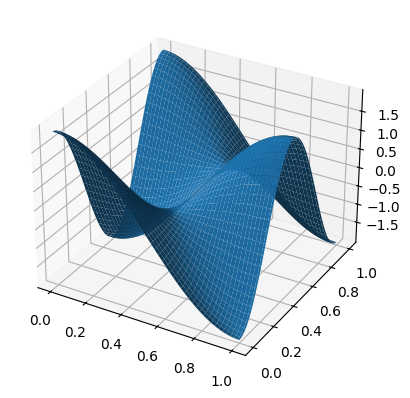

In [54]:
fig,ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_grid,y_grid,basis[(1,2)])

In [55]:
my_mean = np.array([0.5,0.5])
my_cov = np.array([[0.01,0],[0,0.16]])
my_inv_cov = np.linalg.inv(my_cov)
my_det_cov = np.linalg.det(my_cov)

In [56]:
my_pdf = np.zeros_like(x_grid)
for i in range(x_grid.shape[0]):
    for j in range(x_grid.shape[1]):
        xij = x_grid[i,j]
        yij = y_grid[i,j]
        vij = np.array([xij,yij])
        fij = np.exp(-0.5*np.transpose((vij-my_mean))@my_inv_cov@(vij-my_mean))/np.sqrt(4*np.pi*np.pi*my_det_cov)
        my_pdf[i,j] = fij

In [57]:
# optional overwrite with uniform
#my_pdf = np.ones_like(x_grid)/(length_x*length_y)

In [58]:
# uniform in a subset
#my_pdf = (x_grid**2 + y_grid**2 >= 0.6)

In [59]:
my_pdf = my_pdf/inner_product(my_pdf,basis[(0,0)])

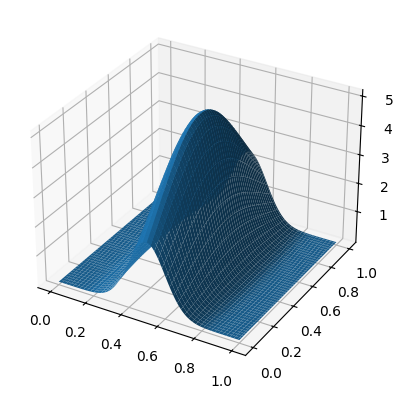

In [60]:
fig,ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_grid,y_grid,my_pdf)

In [61]:
eta = {}
for k in wave_numbers:
    eta[k] = inner_product(my_pdf,basis[k])

In [62]:
fourier_pdf = np.zeros_like(x_grid)
for k in wave_numbers:
    fourier_pdf += eta[k]*basis[k]

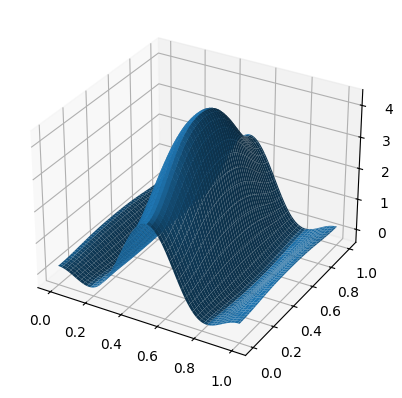

In [63]:
fig,ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_grid,y_grid,fourier_pdf)

In [64]:
wp_num_x = 6
wp_num_y = 6

In [65]:
# square mesh
x_wp,y_wp = np.meshgrid(np.linspace(0,length_x,wp_num_x),np.linspace(0,length_x,wp_num_y))

In [66]:
# convert to triangular mesh
x_wp[1::2,:] = x_wp[1::2,:] + 0.5*length_x/(wp_num_x-1)
x_wp = x_wp*(wp_num_x-1)/(wp_num_x-0.5)
y_wp = y_wp*np.cos(np.pi/6.0)*(wp_num_x-1)/(wp_num_x-0.5)
y_wp = y_wp + 0.5*length_y-np.median(y_wp,axis=None)
# seems dramatically slower

In [67]:
num_wp = wp_num_x*wp_num_y

In [68]:
wp_array = np.vstack((np.reshape(x_wp,(1,x_wp.size)),np.reshape(y_wp,(1,y_wp.size))))

In [69]:
links = [(i,j) for i in range(x_wp.size) for j in range(x_wp.size) if i!=j and np.linalg.norm(wp_array[:,i] - wp_array[:,j])<=1.1*length_x/(wp_num_x-1)]

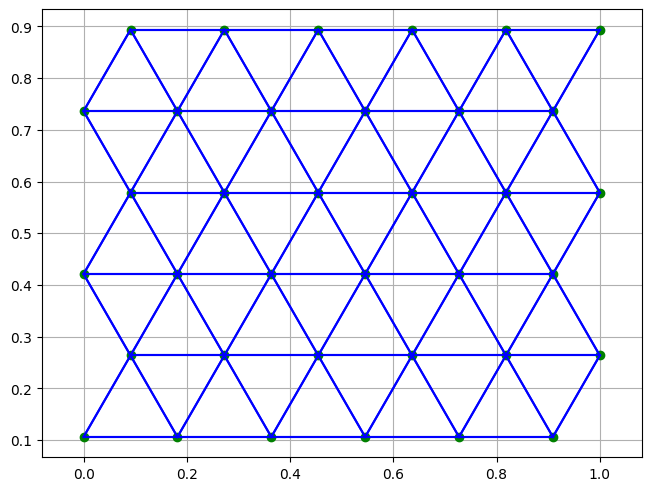

In [70]:
fig,ax = plt.subplots(layout='constrained')
ax.plot(x_wp,y_wp,'go')
for (i,j) in links:
    if i!=-1 and j!=-1:
        plt.plot(wp_array[0,[i,j]],wp_array[1,[i,j]],'b-')
ax.axis('equal')
ax.grid('on')

In [71]:
# add a magic node for start and finish
links += [(-1,i) for i in range(num_wp)]
links += [(i,-1) for i in range(num_wp)]

In [72]:
wp_list = [-1] + [i for i in range(num_wp)]

In [73]:
prob = pulp.LpProblem('ergo')

In [74]:
x = pulp.LpVariable.dicts("x",links,0,1,pulp.LpInteger)

In [75]:
# continuity - must leave everywhere we go
for w in wp_list:
    prob.addConstraint(sum([x[i,j] for (i,j) in links if i==w]) == sum(sum([x[i,j] for (i,j) in links if j==w])))

In [76]:
# can't go anywhere twice - would be nice to omit this, but then how to include subtours?
for w in wp_list:
    prob.addConstraint(sum([x[i,j] for (i,j) in links if i==w]) <= 1)

In [77]:
v = pulp.LpVariable.dicts("v",[-1]+[i for i in range(num_wp)],0,num_wp,pulp.LpContinuous)

In [78]:
# subtour elimination by MTZ
for (i,j) in links:
    if j!=-1:
        prob.addConstraint(v[j]>=v[i]+1-num_wp*(1-x[i,j]))

In [79]:
num_moves = wp_num_x + wp_num_y
num_moves

12

In [80]:
prob.addConstraint(sum([x[lk] for lk in links])==num_moves)

In [81]:
f_traj = {}
for (i,j) in links:
    if i!=-1 and j!=-1:
        sample_point = 0.5*(wp_array[:,j] + wp_array[:,i])
        for k in wave_numbers:
            f_traj[(i,j,k)] = f_func(sample_point[0],sample_point[1],k[0],k[1],length_x,length_y)

In [82]:
s = pulp.LpVariable.dicts("s",wave_numbers,0,1,pulp.LpContinuous)

In [83]:
lam = {}
for k in wave_numbers:
    lam[k] = 1/(1+k[0]*k[0] + k[1]*k[1])**(3/2)

In [84]:
for k in wave_numbers:
    prob.addConstraint(s[k] >= (eta[k] - sum([f_traj[i,j,k]*x[i,j] for (i,j) in links if i!=-1 and j!=-1])/num_moves))
    prob.addConstraint(s[k] >= -(eta[k] - sum([f_traj[i,j,k]*x[i,j] for (i,j) in links if i!=-1 and j!=-1])/num_moves))

In [85]:
prob.setObjective(sum([lam[k]*s[k] for k in wave_numbers]))

In [86]:
#prob.solve()
prob.solve(solver=pulp.CPLEX_PY())
print(pulp.LpStatus[prob.status])

Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve eliminated 0 rows and 1 columns.
MIP Presolve modified 768 coefficients.
Reduced MIP has 331 rows, 303 columns, and 9440 nonzeros.
Reduced MIP has 242 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (4.71 ticks)
Probing time = 0.00 sec. (1.69 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 331 rows, 303 columns, and 9440 nonzeros.
Reduced MIP has 242 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (4.26 ticks)
Probing time = 0.00 sec. (1.82 ticks)
Clique table members: 122.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution time = 0.00 sec. (8.91 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer

In [87]:
moves = [(i,j) for (i,j) in links if x[i,j].value()>=0.5]
moves

[(2, 8),
 (8, 14),
 (9, 3),
 (14, 20),
 (15, 9),
 (20, 26),
 (21, 15),
 (26, 32),
 (27, 21),
 (32, 27),
 (-1, 2),
 (3, -1)]

(0.0, 1.0, 0.0, 1.0)

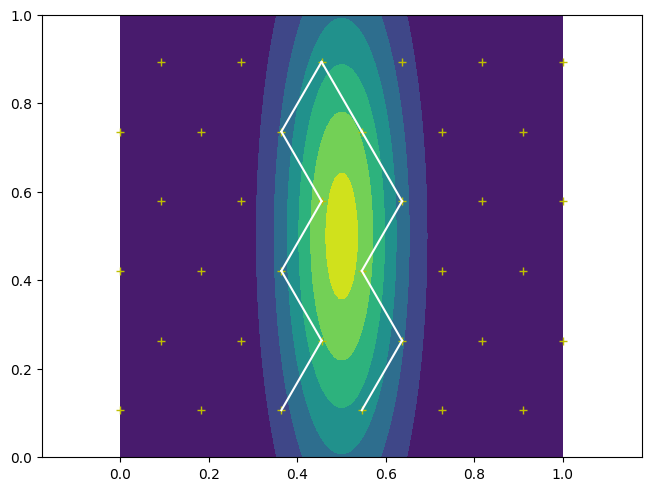

In [90]:
fig,ax = plt.subplots(layout='constrained')
ax.contourf(x_grid,y_grid,my_pdf)
ax.plot(x_wp,y_wp,'y+')
for (i,j) in moves:
    if i!=-1 and j!=-1:
        plt.plot(wp_array[0,[i,j]],wp_array[1,[i,j]],'w-')
ax.axis('equal')